In [2]:
import os
import sys

if 'google.colab' in sys.modules:       # Si on est dans Google Colab
    # Colab : Monter Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    project_path = '/content/drive/MyDrive/internship_cvut'
else:
    # Exécution locale : on se base sur le chemin du fichier
    project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..'))

# Changer le dossier courant vers le dossier du projet
os.chdir(project_path)

# Ajouter src/ au path si nécessaire
src_path = os.path.join(project_path, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Optionnel : vérifier que tout est bien configuré
# print("Répertoire courant :", os.getcwd())
# print("Contenu de src :", os.listdir(src_path))
# print("Contenu de database :", os.listdir(os.path.join(project_path, 'database')))

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


from python_scripts.miscellaneaous.data_processing import extract_data
from python_scripts.road_detection.road_utils import *

In [4]:
# Chargement des données
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider='Orange') #, techno='4g')#, region='Normandie')

xy = df[['x', 'y']].to_numpy()

/tmp/ipython-input-663099287.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


### DBSCAN + PCA (clusters alongés)

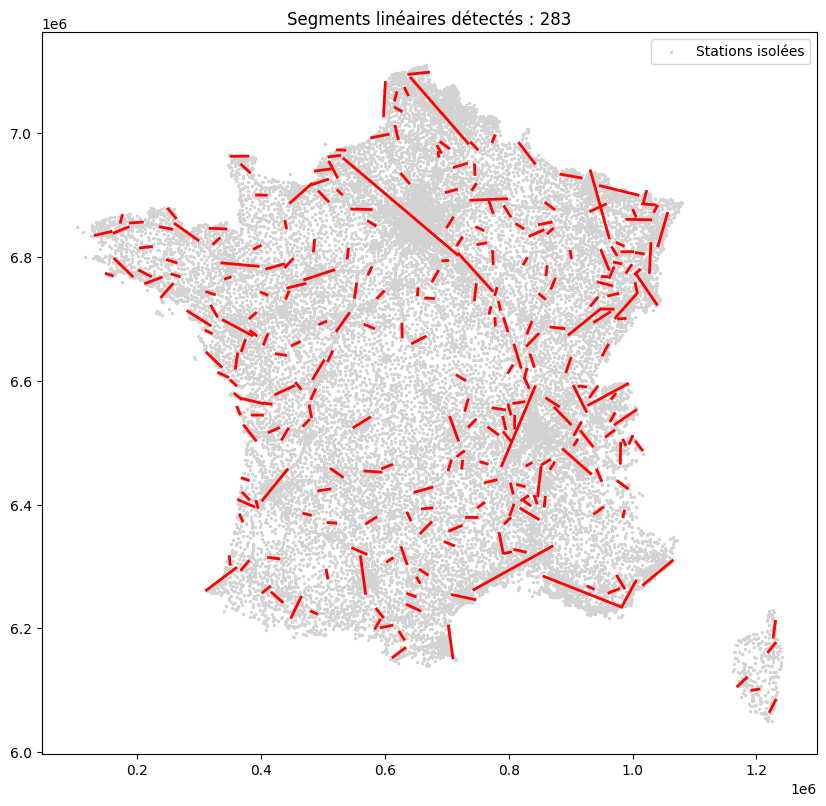

In [ ]:
eps = 6000
min_samples = 9
explained_thresh = 0.6


db = DBSCAN(eps=eps, min_samples=min_samples).fit(xy)           ## eps: maximum distance between two samples for one to be considered as in the neighborhood of the other (en metres)
                                                                ## min_samples : number of samples in a neighborhood for a point to be considered in dense zone. This includes the point itself. If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse. Donc environ = le nombre min de points pour être considéré comme cluster (donc pour pouvoir être une route droite ici)
labels = db.labels_


fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(xy[:, 0], xy[:, 1], s=2, c='lightgray', label='Stations isolées')

n_segments = 0

# Parcours des clusters
for cluster_id in set(labels):
    if cluster_id == -1:
        continue  # ignore le bruit

    cluster_pts = xy[labels == cluster_id]
    if len(cluster_pts) < 4:
        continue

    # PCA sur le cluster
    pca = PCA(n_components=2)
    pca.fit(cluster_pts)
    explained = pca.explained_variance_ratio_

    # Si forte variance sur la 1re composante → cluster "allongé"
    if explained[0] > explained_thresh:                              ## pourcentage de variance de la première composante. Meilleure valeur : 0.6

        # Projette les points sur l'axe principal pour tracer un segment
        proj = pca.transform(cluster_pts)[:, 0]
        idx_min, idx_max = np.argmin(proj), np.argmax(proj)
        pt1, pt2 = cluster_pts[idx_min], cluster_pts[idx_max]

        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'r-', linewidth=2)
        n_segments += 1

ax.set_title(f"Segments linéaires détectés : {n_segments}")
ax.set_aspect('equal')
plt.legend()
plt.show()

### DBScan + PCA, autre version

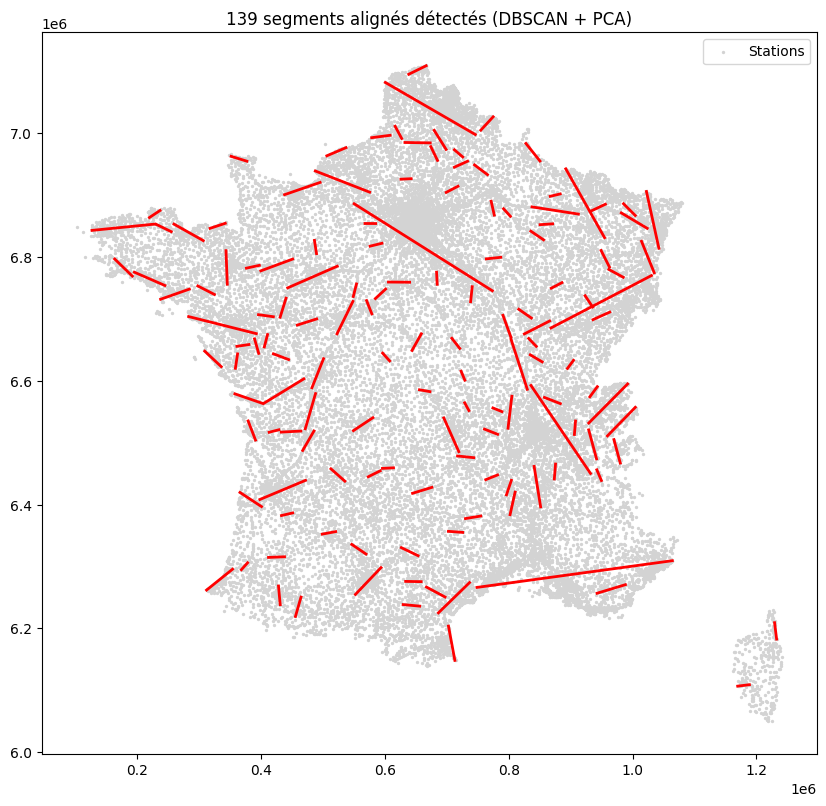

In [ ]:
# Paramètres DBSCAN
db = DBSCAN(eps=5000, min_samples=5)  # à ajuster selon la densité
labels = db.fit_predict(xy)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(xy[:, 0], xy[:, 1], s=2, c='lightgray', label='Stations')

n_segments = 0

for cluster_id in np.unique(labels):
    if cluster_id == -1:
        continue  # bruit

    points = xy[labels == cluster_id]
    if len(points) < 20:      ## Si moins que x points dans le cluster, on l'ignore
        continue

    # PCA pour déterminer l’axe principal
    pca = PCA(n_components=2)
    pca.fit(points)
    direction = pca.components_[0]
    explained_var = pca.explained_variance_ratio_[0]

    # Seulement si les points sont bien alignés
    if explained_var < 0.5:
        continue  # ce cluster n'est pas linéaire

    # Projeter les points sur l'axe principal
    proj = points @ direction
    idx_min, idx_max = np.argmin(proj), np.argmax(proj)
    pt1, pt2 = points[idx_min], points[idx_max]

    # Tracer le segment
    ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'r-', linewidth=2)
    n_segments += 1

ax.set_aspect('equal')
ax.set_title(f"{n_segments} segments linéaires détectés")
plt.legend()
plt.show()

### Tuiles + PCA linéaire dans chaque tuile

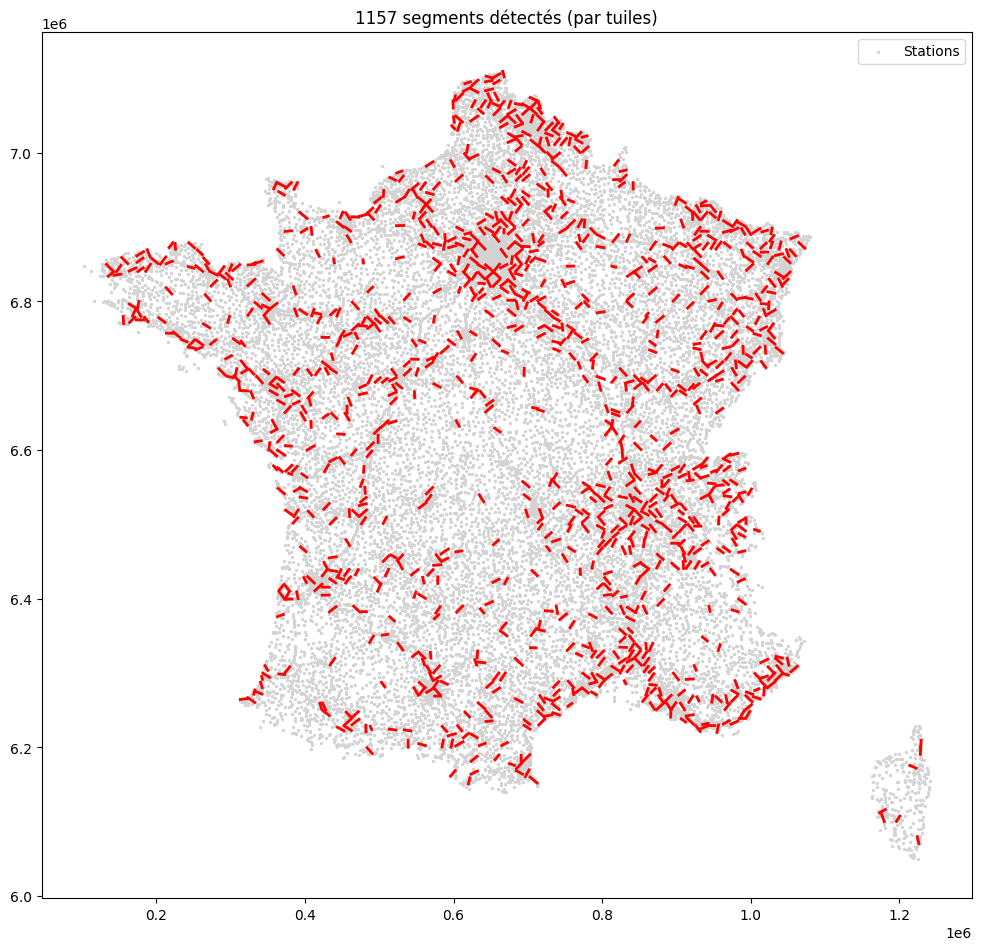

In [22]:
# Paramètres
tile_size = 10000  # en metre
min_points = 6
min_var_ratio = 0.6  # Linéarité minimum

# Si 5000, 5, 0.6 : on détecte plutôt des villes.
# Si 10000, 6 (ou 5 ou 7), 0.6 : on voit des trucs mais un peu brouillon

# Définition de la grille
x_min, x_max = xy[:, 0].min(), xy[:, 0].max()
y_min, y_max = xy[:, 1].min(), xy[:, 1].max()

tiles_x = np.arange(x_min, x_max, tile_size)
tiles_y = np.arange(y_min, y_max, tile_size)

segments = []

for x0 in tiles_x:
    for y0 in tiles_y:
        x1 = x0 + tile_size
        y1 = y0 + tile_size

        # Points dans la tuile
        mask = (xy[:, 0] >= x0) & (xy[:, 0] < x1) & (xy[:, 1] >= y0) & (xy[:, 1] < y1)
        tile_points = xy[mask]

        if len(tile_points) < min_points:
            continue  # trop peu de points

        # PCA sur les points de la tuile
        pca = PCA(n_components=2)
        pca.fit(tile_points)
        direction = pca.components_[0]
        explained_var = pca.explained_variance_ratio_[0]

        if explained_var < min_var_ratio:
            continue  # pas assez linéaire

        # Projection des points sur le vecteur principal
        projections = tile_points @ direction
        idx_min, idx_max = np.argmin(projections), np.argmax(projections)
        pt1 = tile_points[idx_min]
        pt2 = tile_points[idx_max]
        segments.append((pt1, pt2))

# Affichage
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(xy[:, 0], xy[:, 1], s=2, c='lightgray', label='Stations')
for pt1, pt2 in segments:
    ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'r-', linewidth=2)
ax.set_aspect('equal')
ax.set_title(f"{len(segments)} segments détectés (par tuiles)")
plt.legend()
plt.show()

### Algo "Smart Hough simplifié" (vecteurs d'alignement par fenêtres mobiles)

~ KNN+PCA, puis clusters des segments trouvés

Étapes :

    Pour chaque station, cherche ses k plus proches voisines.

    Si elles sont à peu près alignées, définit un segment local.

    Stocke le segment avec son orientation.

    Ensuite, regroupe (clusterise) les segments par orientation + position.

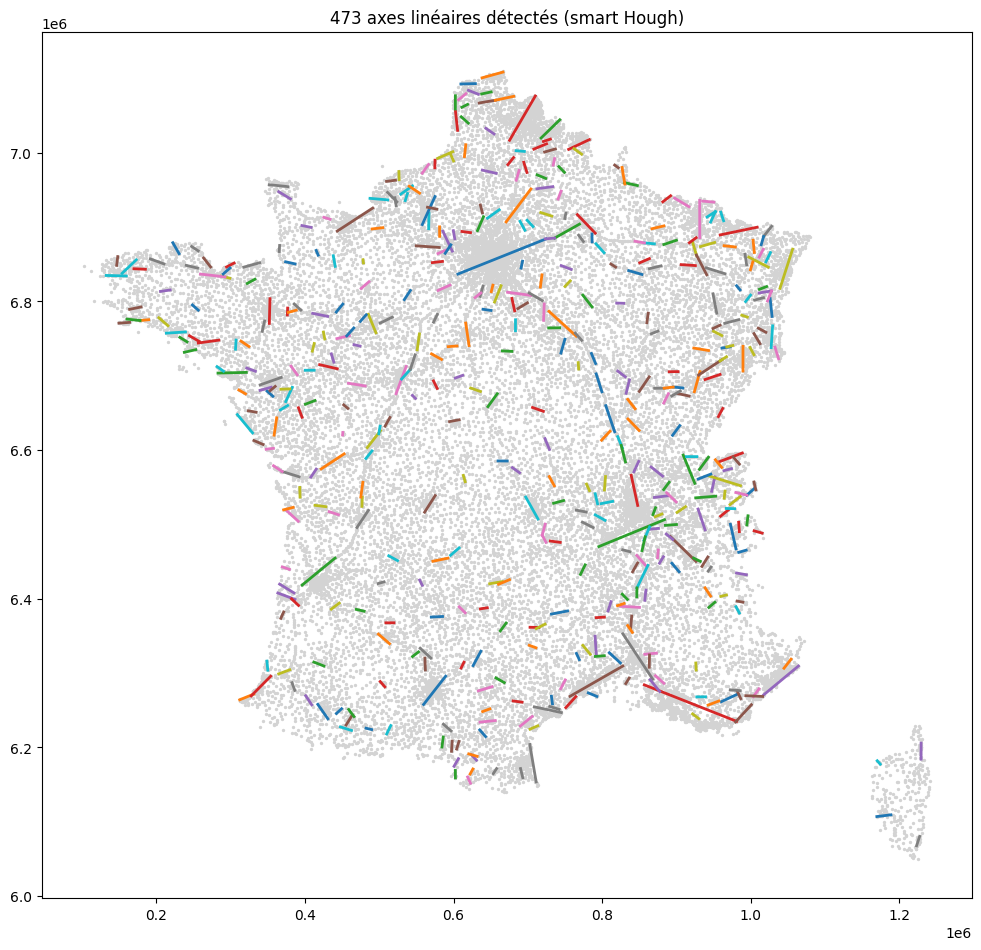

In [ ]:
# Paramètres
r = 5000               # Rayon de recherche autour de chaque station (en mètres)
min_pts = 6            # Nb minimal de voisins pour considérer l’alignement
linearity_thresh = 0.6

segment_list = []

# Détection de segments locaux
nbrs = NearestNeighbors(radius=r).fit(xy)
for i, pt in enumerate(xy):
    indices = nbrs.radius_neighbors([pt], return_distance=False)[0]
    if len(indices) < min_pts:
        continue

    local_points = xy[indices]
    pca = PCA(n_components=2)
    pca.fit(local_points)
    var_ratio = pca.explained_variance_ratio_[0]
    if var_ratio < linearity_thresh:
        continue

    direction = pca.components_[0]
    projections = local_points @ direction
    idx_min, idx_max = np.argmin(projections), np.argmax(projections)
    pt1, pt2 = local_points[idx_min], local_points[idx_max]
    center = (pt1 + pt2) / 2
    angle = np.arctan2(direction[1], direction[0])  # Orientation

    segment_list.append({
        'pt1': pt1,
        'pt2': pt2,
        'center': center,
        'angle': angle
    })

# Clustering des segments par (x, y, angle)
segment_centers = np.array([s['center'] for s in segment_list])
angles = np.array([s['angle'] for s in segment_list])
angle_cos = np.cos(angles)
angle_sin = np.sin(angles)
X = np.hstack([segment_centers, angle_cos[:, None], angle_sin[:, None]])

seg_clusters = DBSCAN(eps=4000, min_samples=3).fit(X)   # DBSCAN sur (x, y, orientation)
labels = seg_clusters.labels_

# Moyenniser les segments par cluster
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(xy[:, 0], xy[:, 1], s=2, color='lightgray', label='Stations')

n_final = 0
for lbl in np.unique(labels):
    if lbl == -1:
        continue
    cluster_segs = [segment_list[i] for i in range(len(segment_list)) if labels[i] == lbl]
    all_pts = np.vstack([s['pt1'] for s in cluster_segs] + [s['pt2'] for s in cluster_segs])
    pca = PCA(n_components=2)
    pca.fit(all_pts)
    direction = pca.components_[0]
    proj = all_pts @ direction
    pt1 = all_pts[np.argmin(proj)]
    pt2 = all_pts[np.argmax(proj)]
    ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], '-', linewidth=2, label=f"axe {lbl}")
    n_final += 1

ax.set_title(f"{n_final} axes linéaires détectés (smart Hough)")
ax.set_aspect('equal')
plt.show()

### Graphe orienté + suivi de chemin

    Construit un graphe où les sommets sont les stations

    Met une arête entre 2 stations proches si elles s’alignent bien avec une 3e

    Ensuite, parcourt les chaînes de sommets qui gardent une orientation à peu près stable

/tmp/ipython-input-11-983442274.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')
/content/drive/MyDrive/internship_cvut/src/python_scripts/road_detection/road_utils.py:100: RuntimeWarning: invalid value encountered in divide
  unit_v2 = v2 / np.linalg.norm(v2)
/content/drive/MyDrive/internship_cvut/src/python_scripts/road_detection/road_utils.py:99: RuntimeWarning: invalid value encountered in divide
  unit_v1 = v1 / np.linalg.norm(v1)


19959 arêtes ajoutées entre 9199 stations.
44158 chemins détectés (longueur ≥ 6)


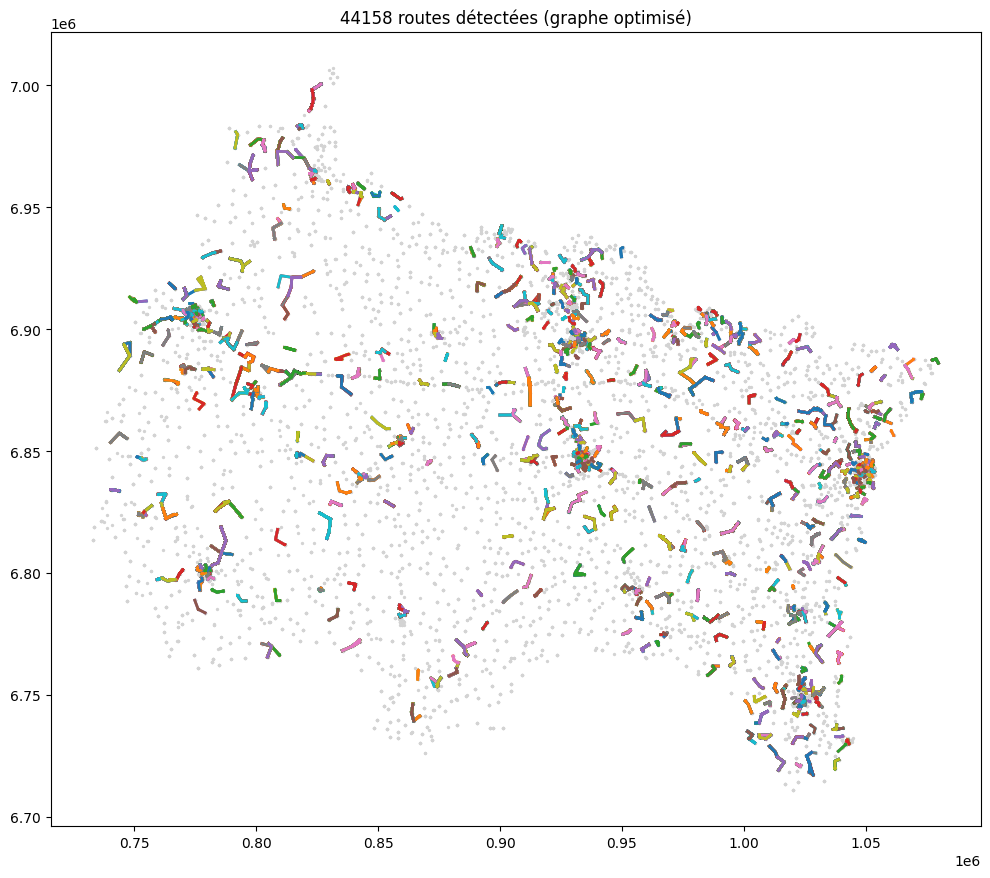

In [ ]:
import networkx as nx

# Chargement des données
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, region='Grand Est') #, provider="Orange") #, techno="4G")
xy = df[['x', 'y']].to_numpy()

# Paramètres
k = 5                     # nb de voisins (réduction forte)
angle_threshold = 25      # Degré max pour considérer que 3 points sont alignés
min_chain_length = 6

# Étape 1 : construire le graphe orienté
G = nx.DiGraph()
nbrs = NearestNeighbors(n_neighbors=k).fit(xy)

distances, indices = nbrs.kneighbors(xy)

for i, neighbors in enumerate(indices):
    neighbors = neighbors[1:]  # on enlève soi-même
    for j in neighbors:
        for k_ in neighbors:
            if k_ == j:
                continue
            v1 = xy[i] - xy[k_]
            v2 = xy[j] - xy[i]
            angle = angle_between(v1, v2)
            if abs(angle - 180) < angle_threshold:
                G.add_edge(i, j)
                break

print(f"{G.number_of_edges()} arêtes ajoutées entre {G.number_of_nodes()} stations.")

# Étape 2 : exploration limitée (DFS)
def dfs_paths(graph, start, max_depth):
    stack = [(start, [start])]
    paths = []
    while stack:
        node, path = stack.pop()
        if len(path) >= min_chain_length:
            paths.append(path)
        if len(path) >= max_depth:
            continue
        for neighbor in graph.successors(node):
            if neighbor not in path:
                stack.append((neighbor, path + [neighbor]))
    return paths

# Étape 3 : exploration de tous les chemins
all_paths = set()
for node in G.nodes:
    paths = dfs_paths(G, node, max_depth=6)
    for p in paths:
        all_paths.add(tuple(p))  # pour éviter les doublons

print(f"{len(all_paths)} chemins détectés (longueur ≥ {min_chain_length})")

# Étape 4 : affichage
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(xy[:, 0], xy[:, 1], s=2, c='lightgray', label='Stations')

for path in all_paths:
    coords = xy[list(path)]
    ax.plot(coords[:, 0], coords[:, 1], '-', lw=2)

ax.set_title(f"{len(all_paths)} routes détectées (graphe optimisé)")
ax.set_aspect('equal')
plt.show()